In [1]:
import os
import cv2
import mediapipe as mp
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

In [2]:
# Paths to datasets
video_path = '../data/ZJ-videos'
alphabet_path = '../data/mnist_asl_alphabet_train'

In [31]:
# Set the number of frames to pad to
selected_frame_dim = 129  # Example value
padding_value = torch.zeros((21, 3), dtype=torch.float32)  # Padding value

# Target size for resizing frames and images
target_size = (224, 224)

# Label mapping
label_mapping = {'J': 0, 'Z': 1, 'nothing': 2}

In [32]:
# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

I0000 00:00:1721332206.390187 3324514 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1721332206.413814 3324674 gl_context.cc:357] GL version: 3.1 (OpenGL ES 3.1 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: D3D12 (NVIDIA GeForce RTX 3060)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [33]:
# Augment an image
def augment_image(image, flip=False):
    # Random rotation
    angle = random.uniform(-5, 5)
    height, width = image.shape[:2]
    M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (width, height))
    
    # Flip horizontally if specified
    if flip:
        rotated = cv2.flip(rotated, 1)
    
    return rotated

In [34]:
# Returns list of tuples of videos, with their corresponding label
def load_videos(path, label):
    video_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.avi')]
    video_files.sort()
    return [(f, label_mapping[label]) for f in video_files]

# Returns list of tuples of images, with their corresponding label
def load_images(path, labels):
    image_files = []
    for label in labels:
        files = [os.path.join(path, label, f) for f in os.listdir(os.path.join(path, label)) if f.endswith('.jpg')]
        files = random.sample(files, 12)  # Take 12 images per label
        image_files.extend([(f, label_mapping['nothing']) for f in files])  # Label all images as 'nothing'
    return image_files

# [(x, y), (x, y),..,]

In [35]:
# Load and process datasets
video_files = load_videos(os.path.join(video_path, 'j'), 'J') + load_videos(os.path.join(video_path, 'z'), 'Z')
image_files = load_images(alphabet_path, list('ABCDEFGHIKLMNOPQRSTUVWXY'))
train_videos, val_videos = train_test_split(video_files, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

In [36]:
def extract_landmarks_from_video(video_file, target_size=(224, 224), selected_frame_dim=180, min_valid_frames=90, flip=False):
    cap = cv2.VideoCapture(video_file)
    frames = []
    corrupted_video = False

    # Get the list of frame landmarks
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)  # Resize frame
        frame = augment_image(frame, flip=flip)  # Apply augmentation with consistent flipping
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                frame_landmarks = torch.tensor([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark], dtype=torch.float32) # (21, 3)
                frames.append(frame_landmarks)  # Add a batch dimension
        # If no hand detected, skip the frame

    cap.release()

    # Check if video frames meets bounding function. If not, then return None
    if len(frames) < min_valid_frames:
        corrupted_video = True

    if corrupted_video:
        return None, True

    # Pad or trim frames to the selected frame dimension
    padded_frames_tensor = pad_sequence(frames, selected_frame_dim, padding_value=torch.zeros((21, 3), dtype=torch.float32)) # ((120, 21, 3)
    
    return padded_frames_tensor, False


### ------------------------------------------------------------------------------------------------------------------------------------------

# Function to extract landmarks from an image
def extract_landmarks_from_image(image_file, target_size=(224, 224), desired_frames=180, min_valid_frames=90, flip=False):
    frames = []
    for _ in range(desired_frames):
        image = cv2.imread(image_file)
        if image is None:
            return None, True  # Mark as corrupted if image cannot be read

        image = cv2.resize(image, target_size)  # Resize image
        augmented_image = augment_image(image, flip=flip)  # Apply augmentation with consistent flipping
        image_rgb = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                frame_landmarks = torch.tensor([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark], dtype=torch.float32)
                frames.append(frame_landmarks)

    # Check if image frames meet bounding function
    if len(frames) < min_valid_frames:
        return None, True

    # Pad or trim frames to the selected frame dimension
    padded_frames_tensor = pad_sequence(frames, desired_frames, padding_value=torch.zeros((21, 3), dtype=torch.float32))
    
    return padded_frames_tensor, False

In [37]:
def pad_sequence(sequence, target_length, padding_value):
    padded_sequence = sequence[:target_length]  # Trim to the target length if necessary
    while len(padded_sequence) < target_length:
        padded_sequence.append(padding_value)
    return torch.stack(padded_sequence)

In [38]:
def process_videos(video_files, target_size=(224, 224), selected_frame_dim=120, min_valid_frames=60):
    data = []
    labels = []
    # Unpack tuples
    for video_file, label in tqdm(video_files, desc='Processing videos'):
        flip = random.choice([True, False])  # Randomly choose to flip or not flip
        landmarks, is_corrupted = extract_landmarks_from_video(video_file, target_size, selected_frame_dim, min_valid_frames, flip=flip) # (120, 21, 3)
        if not is_corrupted and landmarks is not None:
            data.append(landmarks)
            labels.append(label)
    return torch.stack(data), torch.tensor(labels, dtype=torch.int64)



# Process images
def process_images(image_files, desired_frames=120, min_valid_frames=90):
    data = []
    labels = []
    for image_file, label in tqdm(image_files, desc='Processing images'):
        flip = random.choice([True, False])  # Randomly choose to flip or not flip
        landmarks, is_corrupted = extract_landmarks_from_image(image_file, desired_frames=desired_frames, min_valid_frames=min_valid_frames, flip=flip)
        if not is_corrupted and landmarks is not None:
            data.append(landmarks)
            labels.append(label)
    return torch.stack(data), torch.tensor(labels, dtype=torch.int64)

In [39]:
train_image_data, train_image_labels = process_images(train_images)
val_image_data, val_image_labels = process_images(val_images)

Processing images: 100%|█████████████████████████████████████████████████████████████████| 58/58 [01:11<00:00,  1.23s/it]


In [40]:
train_video_data, train_video_labels = process_videos(train_videos)
val_video_data, val_video_labels = process_videos(val_videos)

Processing videos: 100%|███████████████████████████████████████████████████████████████| 143/143 [02:23<00:00,  1.00s/it]


In [45]:
train_data = torch.cat((train_video_data, train_image_data), dim=0)
train_labels = torch.cat((train_video_labels, train_image_labels), dim=0)

val_data = torch.cat((val_video_data, val_image_data), dim=0)
val_labels = torch.cat((val_video_labels, val_image_labels), dim=0)

In [46]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)

torch.Size([629, 120, 21, 3])
torch.Size([629])
torch.Size([167, 120, 21, 3])
torch.Size([167])


In [47]:
val_labels

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [48]:
# Save the data
torch.save((train_data, train_labels), 'train_data.pt')
torch.save((val_data, val_labels), 'val_data.pt')

In [2]:
# Load data
train_data, train_labels = torch.load('train_data.pt')
val_data, val_labels = torch.load('val_data.pt')

Label for selected example: 2


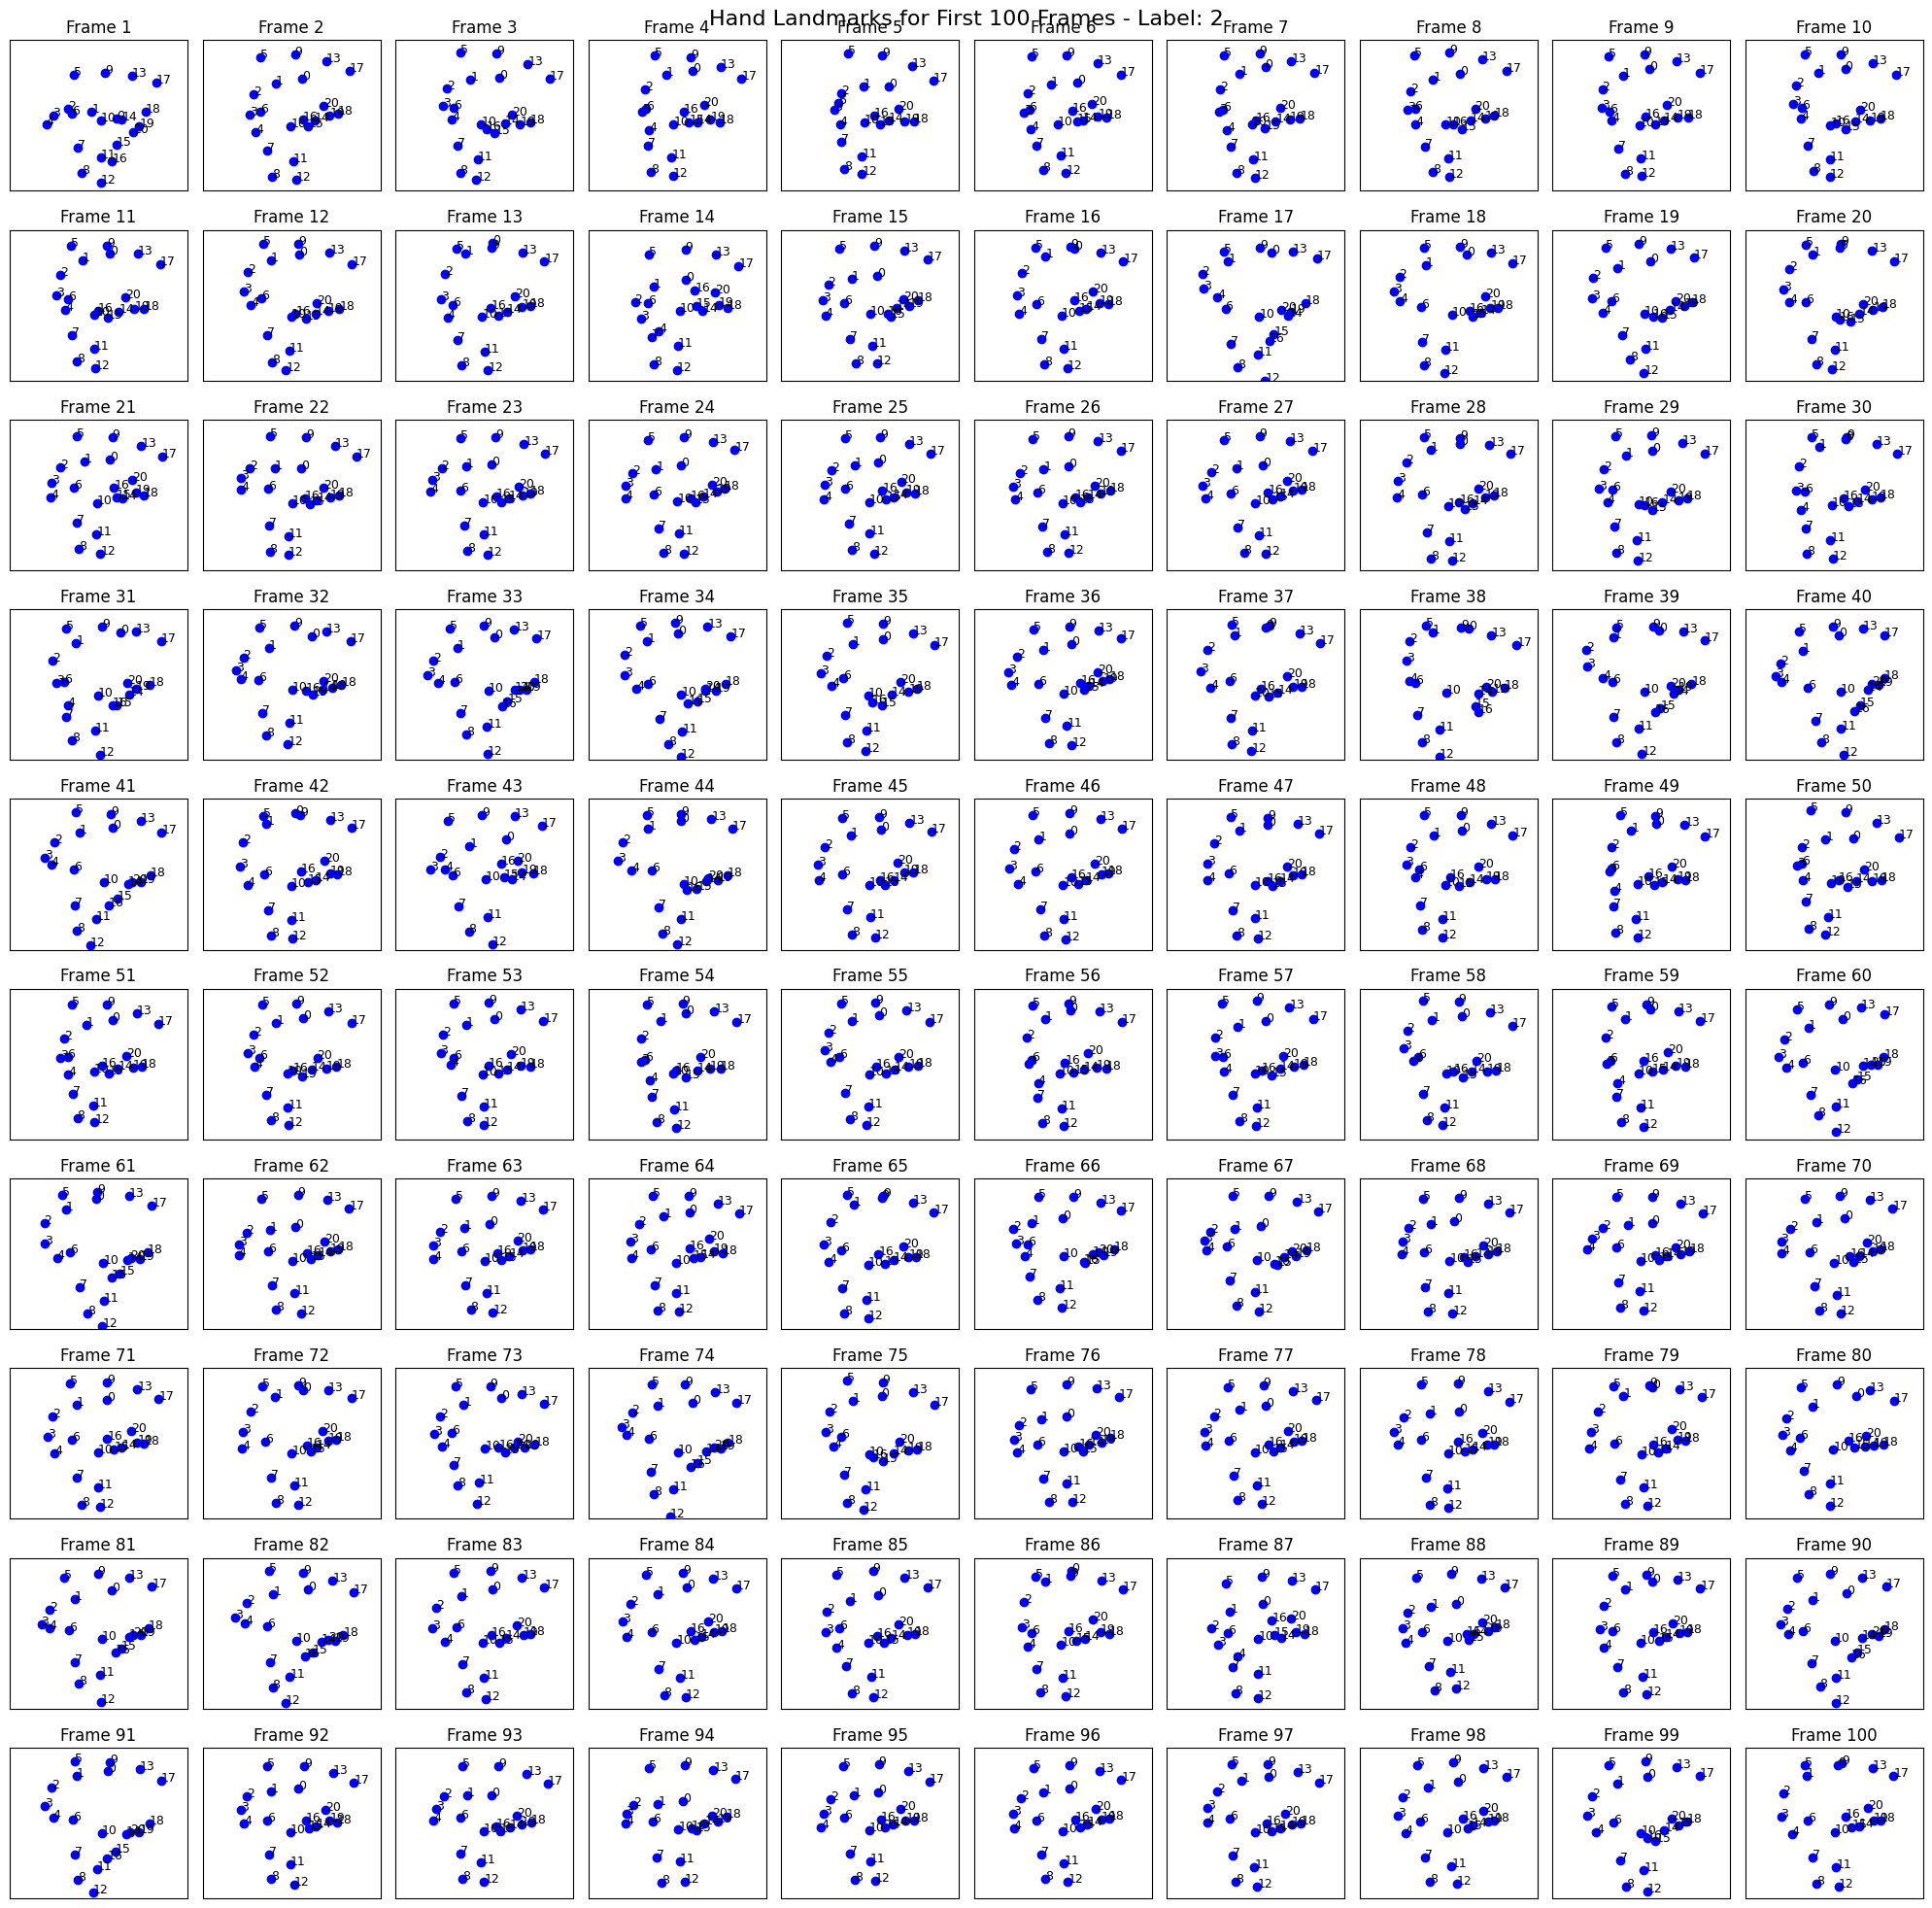

In [46]:
# Visualize train data
def visualize_data(data, labels, num_examples=100):
    # Select a random example from the data
    # print(random_idx)
    random_idx = random.randint(0, data.shape[0] - 1)
    selected_data = data[random_idx][:num_examples]  # Take the first 50 frames
    selected_label = labels[random_idx].item()
    selected_data = selected_data.reshape(-1, 21, 3)

    # Print the respective label
    print(f"Label for selected example: {selected_label}")

    # Plot the hand landmarks for each frame
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    fig.suptitle(f'Hand Landmarks for First {num_examples} Frames - Label: {selected_label}', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i >= selected_data.shape[0]:
            break
        ax.scatter(selected_data[i, :, 0], selected_data[i, :, 1], c='b', marker='o')
        for j in range(selected_data.shape[1]):
            ax.text(selected_data[i, j, 0], selected_data[i, j, 1], str(j), fontsize=9)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Frame {i+1}')

    plt.tight_layout()
    plt.show()

# Visualize train data
visualize_data(train_data, train_labels)

In [4]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)

In [5]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out, wei


In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = []
        attn_weights = []
        for h in self.heads:
            head_out, head_attn = h(x)
            out.append(head_out)
            attn_weights.append(head_attn)
        out = torch.cat(out, dim=-1)
        out = self.dropout(self.proj(out))
        attn_weights = torch.stack(attn_weights, dim=1)
        return out, attn_weights

In [7]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        sa_out, attn_weights = self.sa(self.ln1(x))
        x = x + sa_out
        x = x + self.ffwd(self.ln2(x))
        return x, attn_weights


In [8]:
class SignLanguageTransformer(nn.Module):
    def __init__(self, input_size, num_frames, num_classes):
        super().__init__()
        self.input_proj = nn.Linear(input_size, n_embd)
        # Adding one here, for the extra clas stoken
        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames + 1, n_embd))
        self.cls_token = nn.Parameter(torch.randn(1, 1, n_embd))
        self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.fc = nn.Linear(n_embd, num_classes)

    def forward(self, x):
        B, T, _ = x.shape
        x = self.input_proj(x) # (B, 120, 63) -> (B, 120, n_embd)
        
        cls_tokens = self.cls_token.expand(B, -1, -1) # (1, 1, n_embd) -> (B, 1, n_embd)
        # (B, 1, n_embd) + (B, 120, n_embd) -> ((B, 121, n_embd)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :T+1]
        
        for block in self.blocks:
            x, _ = block(x)

        x = self.ln_f(x) # (B, 121, n_embd)
        x = x[:, 0]  # Take the CLS token representation - (B, 1)
        x = self.fc(x) # (B, 3)
        return x


In [9]:
def create_batch(data, labels, batch_size):
    batch_data = data[:batch_size]
    batch_labels = labels[:batch_size]
    return batch_data, batch_labels

In [10]:
def calculate_average_val_loss(model, val_data, val_labels, batch_size, loss_fn):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    num_complete_batches = len(val_data) // batch_size
    
    with torch.no_grad():
        for i in range(0, num_complete_batches * batch_size, batch_size):
            batch_data, batch_labels = create_batch(val_data[i:], val_labels[i:], batch_size)
            
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_data)
            loss = loss_fn(outputs, batch_labels)
            total_loss += loss.item()
            num_batches += 1
    
    average_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    return average_loss

In [11]:
# Hyperparameters
batch_size = 32
n_embd = 256
n_head = 8
n_layer = 6
dropout = 0.1
# max_grad_norm = 1.0
nepochs = 50
learning_rate = 1e-3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
# Reshape the input data
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], -1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], -1)

In [14]:
input_size = train_data.shape[2]  # Should be 63
num_frames = train_data.shape[1]  # Should be 120
num_classes = 3  # J, Z, or nothing

In [23]:
def count_labels(labels, name):
    unique, counts = torch.unique(labels, return_counts=True)
    print(f"\n{name} label distribution:")
    for value, count in zip(unique, counts):
        print(f"Label {value}: {count}")

# For train_labels
count_labels(train_labels, "Training")

# For val_labels
count_labels(val_labels, "Validation")


Training label distribution:
Label 0: 191
Label 1: 236
Label 2: 202

Validation label distribution:
Label 0: 60
Label 1: 54
Label 2: 53


In [18]:
model = SignLanguageTransformer(input_size, num_frames, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs)

In [19]:
# Calculate number of model parameters
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("This model Has %d Parameters, %d Million" % (num_model_params, num_model_params//1e6 ) )

This model Has 4782851 Parameters, 4 Million


In [22]:
# Training loop
for epoch in range(nepochs):
    print(f"Epoch {epoch+1}/{nepochs}")
    print("Training:")
    
    # Shuffle the dataset
    indices = torch.randperm(len(train_data))
    train_data = train_data[indices]
    train_labels = train_labels[indices]
    
    model.train()
    epoch_loss = 0
    num_batches = 0

    interval_loss = 0
    interval_batches = 0
    print_interval = 30

    num_complete_batches = len(train_data) // batch_size
    
    for i in range(0, num_complete_batches * batch_size, batch_size):

        batch_data, batch_labels = create_batch(train_data[i:], train_labels[i:], batch_size)

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        
        outputs = model(batch_data)
        
        loss = loss_fn(outputs, batch_labels)
        
        epoch_loss += loss.item()
        interval_loss += loss.item()
        num_batches += 1
        interval_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if interval_batches == print_interval:
            avg_interval_loss = interval_loss / interval_batches
            print(f"Batch {i//batch_size+1}/{num_complete_batches}, Avg Interval Loss: {avg_interval_loss:.4f}")
            interval_loss = 0
            interval_batches = 0

    avg_train_loss = epoch_loss / num_batches
    print(f"Avg Train Loss: {avg_train_loss:.4f}")

    # Validation
    print("Evaluating:")
    val_loss = calculate_average_val_loss(model, val_data, val_labels, batch_size, loss_fn)
    print(f"Avg Val Loss: {val_loss:.4f}")

    # Update learning rate
    scheduler.step()

Epoch 1/50
Training:
Avg Train Loss: 0.4838
Evaluating:
Avg Val Loss: 0.4561
Epoch 2/50
Training:
Avg Train Loss: 0.4512
Evaluating:
Avg Val Loss: 0.4937
Epoch 3/50
Training:
Avg Train Loss: 0.4535
Evaluating:
Avg Val Loss: 0.4551
Epoch 4/50
Training:
Avg Train Loss: 0.4859
Evaluating:
Avg Val Loss: 0.4955
Epoch 5/50
Training:
Avg Train Loss: 0.5049
Evaluating:
Avg Val Loss: 0.6858
Epoch 6/50
Training:
Avg Train Loss: 0.5308
Evaluating:
Avg Val Loss: 0.6333
Epoch 7/50
Training:
Avg Train Loss: 0.5116
Evaluating:
Avg Val Loss: 0.5742
Epoch 8/50
Training:
Avg Train Loss: 0.4907
Evaluating:
Avg Val Loss: 0.5181
Epoch 9/50
Training:
Avg Train Loss: 0.4877
Evaluating:
Avg Val Loss: 0.5084
Epoch 10/50
Training:
Avg Train Loss: 0.4907
Evaluating:
Avg Val Loss: 0.4983
Epoch 11/50
Training:
Avg Train Loss: 0.4815
Evaluating:
Avg Val Loss: 0.5101
Epoch 12/50
Training:
Avg Train Loss: 0.4841
Evaluating:
Avg Val Loss: 0.5130
Epoch 13/50
Training:
Avg Train Loss: 0.4897
Evaluating:
Avg Val Loss: 0.

Randomly selected index: 67
Label for selected example: 1
Predicted class: 1


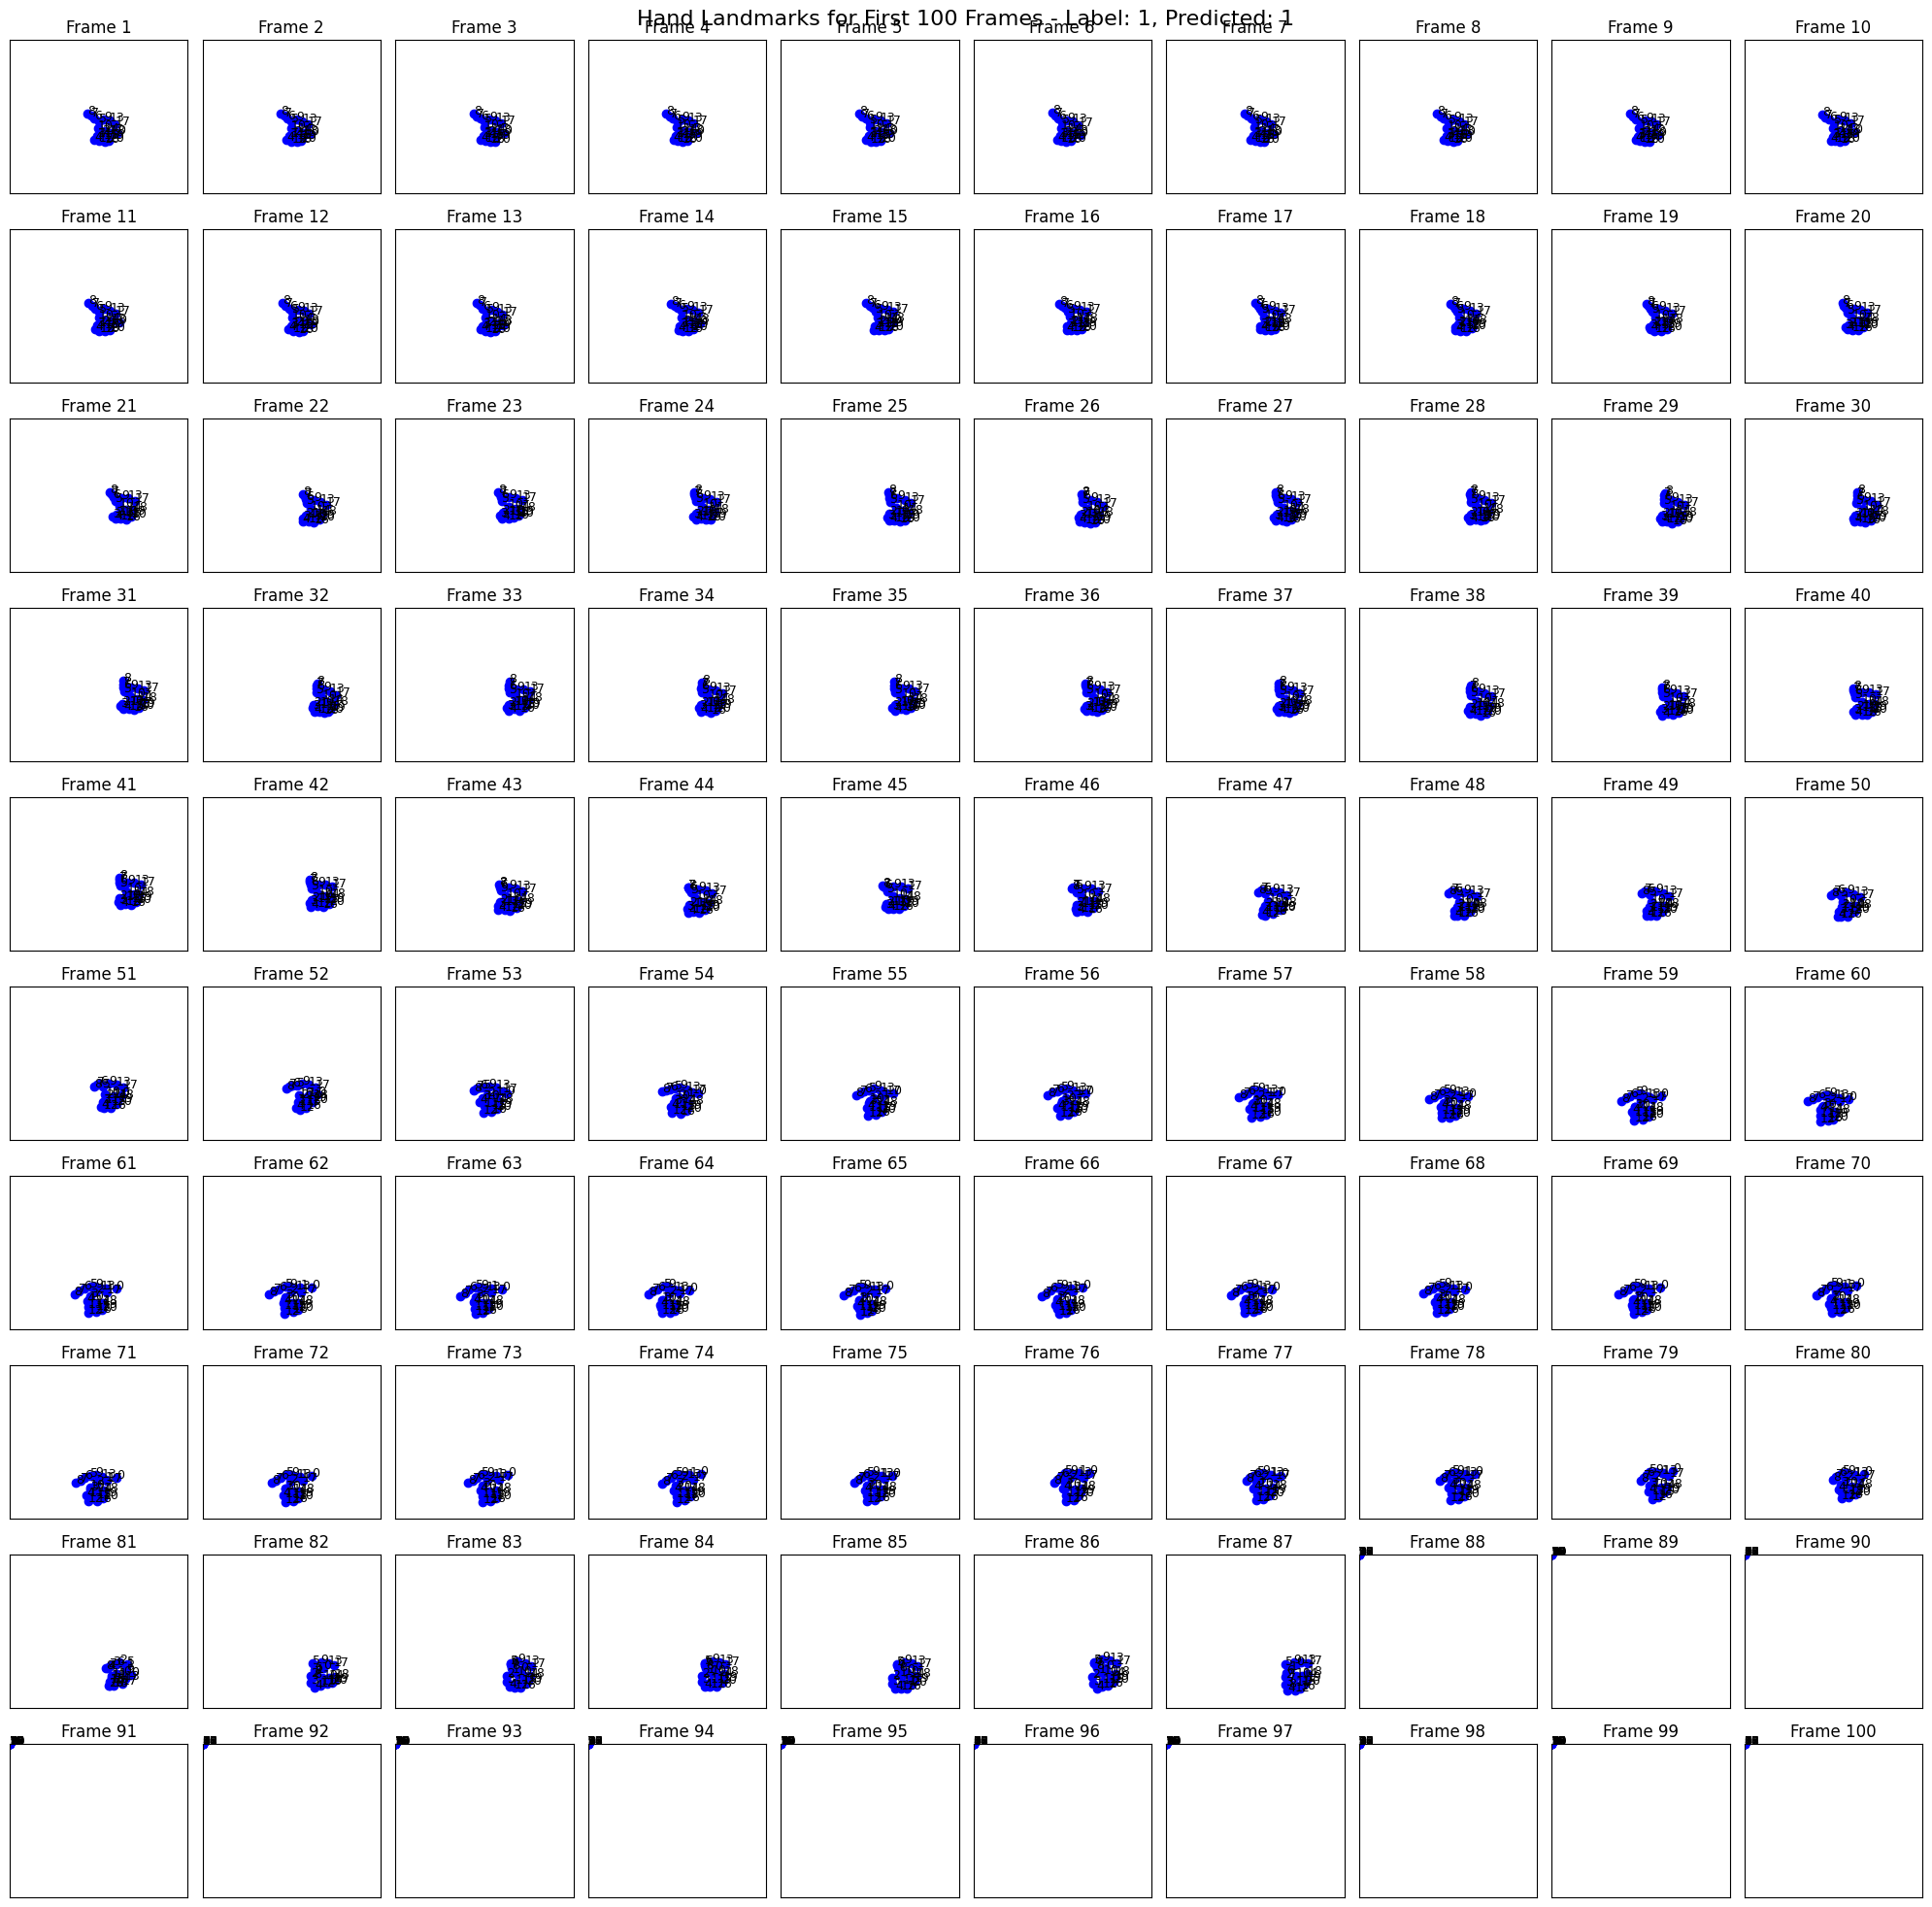

In [51]:
import random
import torch
import matplotlib.pyplot as plt

def visualize_and_predict(model, val_data, val_labels, num_examples=100):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Select a random example from the data
    random_idx = random.randint(0, val_data.shape[0] - 1)
    selected_data = val_data[random_idx][:num_examples]  # Take the first num_examples frames
    selected_label = val_labels[random_idx].item()
    
    print(f"Randomly selected index: {random_idx}")
    print(f"Label for selected example: {selected_label}")
    
    # Get model prediction
    with torch.no_grad():
        output = model(selected_data.unsqueeze(0).to(device))  # Add batch dimension
        predicted_class = torch.argmax(output, dim=1).item()
    
    print(f"Predicted class: {predicted_class}")
    
    # Plot the hand landmarks for each frame
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    fig.suptitle(f'Hand Landmarks for First {num_examples} Frames - Label: {selected_label}, Predicted: {predicted_class}', fontsize=16)

    selected_data = selected_data.reshape(-1, 21, 3)
    
    for i, ax in enumerate(axes.flat):
        if i >= selected_data.shape[0]:
            break
        ax.scatter(selected_data[i, :, 0], selected_data[i, :, 1], c='b', marker='o')
        for j in range(selected_data.shape[1]):
            ax.text(selected_data[i, j, 0], selected_data[i, j, 1], str(j), fontsize=9)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Frame {i+1}')

    plt.tight_layout()
    plt.show()

# Assuming your model is named 'model' and is already trained
# Run the visualization and prediction pipeline
visualize_and_predict(model, val_data, val_labels)

In [31]:
def evaluate_model_accuracy(model, val_data, val_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(val_data.to(device))
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == val_labels.to(device)).sum().item()
        total = val_labels.size(0)
        accuracy = correct / total
    return accuracy

# Evaluate the model's accuracy on the entire validation set
accuracy = evaluate_model_accuracy(model, val_data, val_labels)
print(f"Model accuracy on validation set: {accuracy:.2%}")

Model accuracy on validation set: 98.80%
